## Exploration of domain adaptation algorithms

In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from transfertools.models import CORAL, TCA

%reload_ext autoreload
%autoreload 2

### Simulated data

How do domain adaptation algorithms available in `transfertools` scale with the number of samples/features?

### Real data

Does CORAL help us generalize our mutation prediction classifiers across cancer types?

In [2]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.analysis_utilities as au

In [3]:
lambda_vals = [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]

coral_df = pd.DataFrame()

for lmb in lambda_vals:
    coral_single_cancer_df = au.load_prediction_results(
        os.path.join(cfg.results_dir,
                     'coral',
                     'coral_results_{}'.format(lmb),
                     'single_cancer'),
        'single_cancer'
    )
    coral_single_cancer_df['lambda'] = str(lmb)
    coral_pancancer_df = au.load_prediction_results(
        os.path.join(cfg.results_dir,
                     'coral',
                     'coral_results_{}'.format(lmb),
                     'pancancer_only'),
        'pancancer_only'
    )
    coral_pancancer_df['lambda'] = str(lmb)
    coral_df = pd.concat((coral_df, coral_single_cancer_df, coral_pancancer_df))
coral_df['coral'] = True
coral_df.head()

,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,train_set,identifier,lambda,coral
0,0.97474,0.97905,TP53,LGG,signal,42,train,0,single_cancer,TP53_LGG,0.01,True
1,0.95439,0.94804,TP53,LGG,signal,42,test,0,single_cancer,TP53_LGG,0.01,True
2,0.96536,0.97278,TP53,LGG,signal,42,cv,0,single_cancer,TP53_LGG,0.01,True
3,0.96350,0.97037,TP53,LGG,signal,42,train,1,single_cancer,TP53_LGG,0.01,True
4,0.97469,0.97343,TP53,LGG,signal,42,test,1,single_cancer,TP53_LGG,0.01,True


In [4]:
control_single_cancer_df = au.load_prediction_results(
    os.path.join(cfg.results_dir,
                 'coral',
                 'coral_control',
                 'single_cancer'),
    'single_cancer'
)
control_pancancer_df = au.load_prediction_results(
    os.path.join(cfg.results_dir,
                 'coral',
                 'coral_control',
                 'pancancer_only'),
    'pancancer_only'
)
control_df = pd.concat((control_single_cancer_df, control_pancancer_df))
control_df['lambda'] = '0.0'
control_df['coral'] = False
control_df.head()

,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,train_set,identifier,lambda,coral
0,0.97655,0.98157,TP53,LGG,signal,42,train,0,single_cancer,TP53_LGG,0.0,False
1,0.95589,0.94132,TP53,LGG,signal,42,test,0,single_cancer,TP53_LGG,0.0,False
2,0.95770,0.96404,TP53,LGG,signal,42,cv,0,single_cancer,TP53_LGG,0.0,False
3,0.98295,0.98336,TP53,LGG,signal,42,train,1,single_cancer,TP53_LGG,0.0,False
4,0.97543,0.97588,TP53,LGG,signal,42,test,1,single_cancer,TP53_LGG,0.0,False


Text(0.5, 1.0, 'pancancer only, signal, TP53')

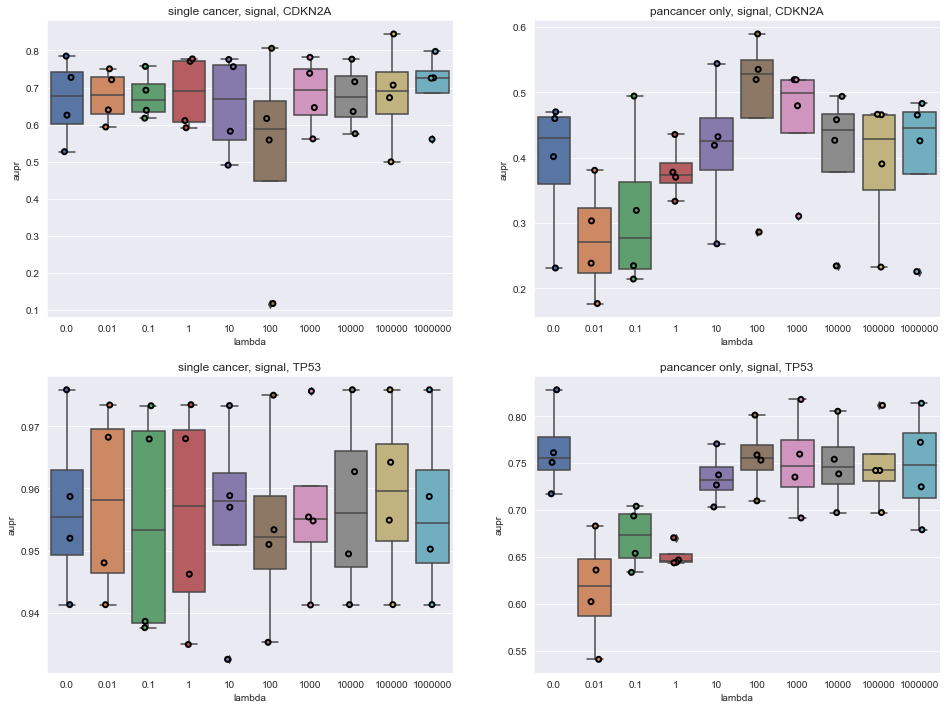

In [5]:
sns.set({'figure.figsize': (16, 12)})
fig, axarr = plt.subplots(2, 2)

results_df = pd.concat((control_df, coral_df))

plot_df = results_df[(results_df.data_type == 'test') &
                     (results_df.signal == 'signal') &
                     (results_df.train_set == 'single_cancer') &
                     (results_df.gene == 'CDKN2A')]
sns.boxplot(data=plot_df, x='lambda', y='aupr', ax=axarr[0, 0])
sns.stripplot(data=plot_df, x='lambda', y='aupr', dodge=True,
              edgecolor='black', linewidth=2, ax=axarr[0, 0])
axarr[0, 0].set_title('single cancer, signal, CDKN2A')
                     
plot_df = results_df[(results_df.data_type == 'test') &
                     (results_df.signal == 'signal') &
                     (results_df.train_set == 'pancancer_only') &
                     (results_df.gene == 'CDKN2A')]
sns.boxplot(data=plot_df, x='lambda', y='aupr', ax=axarr[0, 1])
sns.stripplot(data=plot_df, x='lambda', y='aupr', dodge=True,
              edgecolor='black', linewidth=2, ax=axarr[0, 1])
axarr[0, 1].set_title('pancancer only, signal, CDKN2A')

plot_df = results_df[(results_df.data_type == 'test') &
                     (results_df.signal == 'signal') &
                     (results_df.train_set == 'single_cancer') &
                     (results_df.gene == 'TP53')]
sns.boxplot(data=plot_df, x='lambda', y='aupr', ax=axarr[1, 0])
sns.stripplot(data=plot_df, x='lambda', y='aupr', dodge=True,
              edgecolor='black', linewidth=2, ax=axarr[1, 0])
axarr[1, 0].set_title('single cancer, signal, TP53')
                     
plot_df = results_df[(results_df.data_type == 'test') &
                     (results_df.signal == 'signal') &
                     (results_df.train_set == 'pancancer_only') &
                     (results_df.gene == 'TP53')]
sns.boxplot(data=plot_df, x='lambda', y='aupr', ax=axarr[1, 1])
sns.stripplot(data=plot_df, x='lambda', y='aupr', dodge=True,
              edgecolor='black', linewidth=2, ax=axarr[1, 1])
axarr[1, 1].set_title('pancancer only, signal, TP53')

Text(0.5, 1.0, 'pancancer only, shuffled, TP53')

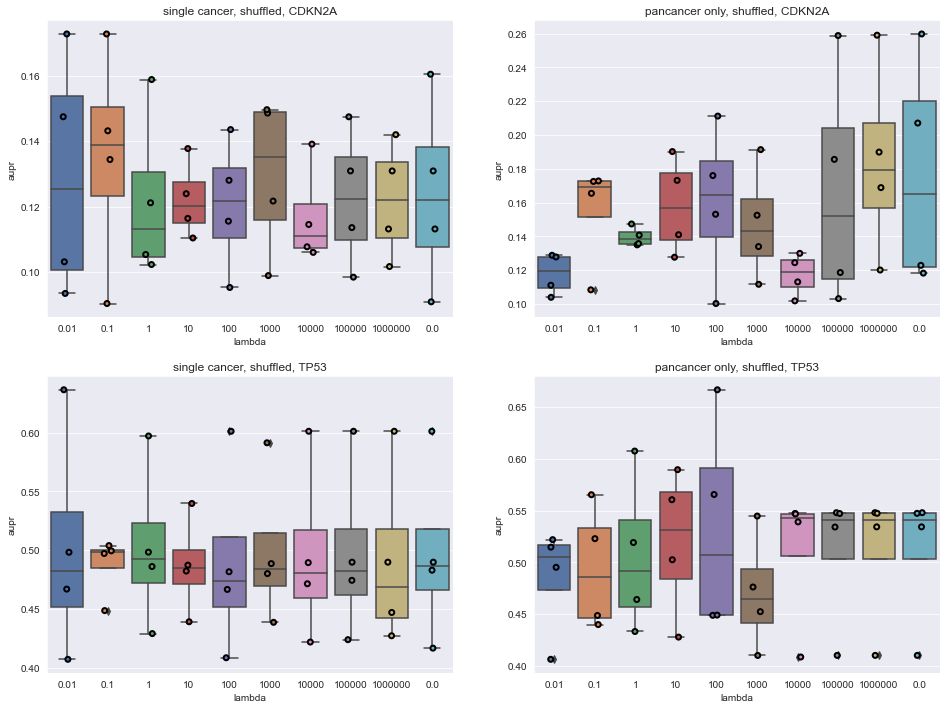

In [6]:
sns.set({'figure.figsize': (16, 12)})
fig, axarr = plt.subplots(2, 2)

results_df = pd.concat((coral_df, control_df))

plot_df = results_df[(results_df.data_type == 'test') &
                     (results_df.signal == 'shuffled') &
                     (results_df.train_set == 'single_cancer') &
                     (results_df.gene == 'CDKN2A')]
sns.boxplot(data=plot_df, x='lambda', y='aupr', ax=axarr[0, 0])
sns.stripplot(data=plot_df, x='lambda', y='aupr', dodge=True,
              edgecolor='black', linewidth=2, ax=axarr[0, 0])
axarr[0, 0].set_title('single cancer, shuffled, CDKN2A')
                     
plot_df = results_df[(results_df.data_type == 'test') &
                     (results_df.signal == 'shuffled') &
                     (results_df.train_set == 'pancancer_only') &
                     (results_df.gene == 'CDKN2A')]
sns.boxplot(data=plot_df, x='lambda', y='aupr', ax=axarr[0, 1])
sns.stripplot(data=plot_df, x='lambda', y='aupr', dodge=True,
              edgecolor='black', linewidth=2, ax=axarr[0, 1])
axarr[0, 1].set_title('pancancer only, shuffled, CDKN2A')

plot_df = results_df[(results_df.data_type == 'test') &
                     (results_df.signal == 'shuffled') &
                     (results_df.train_set == 'single_cancer') &
                     (results_df.gene == 'TP53')]
sns.boxplot(data=plot_df, x='lambda', y='aupr', ax=axarr[1, 0])
sns.stripplot(data=plot_df, x='lambda', y='aupr', dodge=True,
              edgecolor='black', linewidth=2, ax=axarr[1, 0])
axarr[1, 0].set_title('single cancer, shuffled, TP53')
                     
plot_df = results_df[(results_df.data_type == 'test') &
                     (results_df.signal == 'shuffled') &
                     (results_df.train_set == 'pancancer_only') &
                     (results_df.gene == 'TP53')]
sns.boxplot(data=plot_df, x='lambda', y='aupr', ax=axarr[1, 1])
sns.stripplot(data=plot_df, x='lambda', y='aupr', dodge=True,
              edgecolor='black', linewidth=2, ax=axarr[1, 1])
axarr[1, 1].set_title('pancancer only, shuffled, TP53')

In [7]:
diff_results_df = pd.DataFrame()
for train_set in ['single_cancer', 'pancancer_only']:
    for lmb in ['0.0'] + [str(l) for l in lambda_vals]:
        print(lmb)
        data_df = results_df[(results_df.train_set == train_set) &
                             (results_df['lambda'] == lmb)]
        diff_df = au.compare_control_ind(data_df,
                                         identifier='identifier',
                                         metric='aupr',
                                         verbose=True)
        diff_df['train_set'] = train_set
        diff_df['lambda'] = lmb
        diff_df['coral'] = (lmb == 0)
        diff_results_df = pd.concat((diff_results_df, diff_df))
        
diff_results_df.head()

0.0
0.01
0.1
1
10
100
1000
10000
100000
1000000
0.0
0.01
0.1
1
10
100
1000
10000
100000
1000000


,identifier,seed,fold,delta_aupr,train_set,lambda,coral
0,CDKN2A_LGG,42,0,0.636457,single_cancer,0.0,False
1,CDKN2A_LGG,42,1,0.396420,single_cancer,0.0,False
2,CDKN2A_LGG,42,2,0.671690,single_cancer,0.0,False
3,CDKN2A_LGG,42,3,0.465370,single_cancer,0.0,False
4,TP53_LGG,42,0,0.524660,single_cancer,0.0,False


Text(0.5, 1.0, 'pancancer only, TP53_LGG')

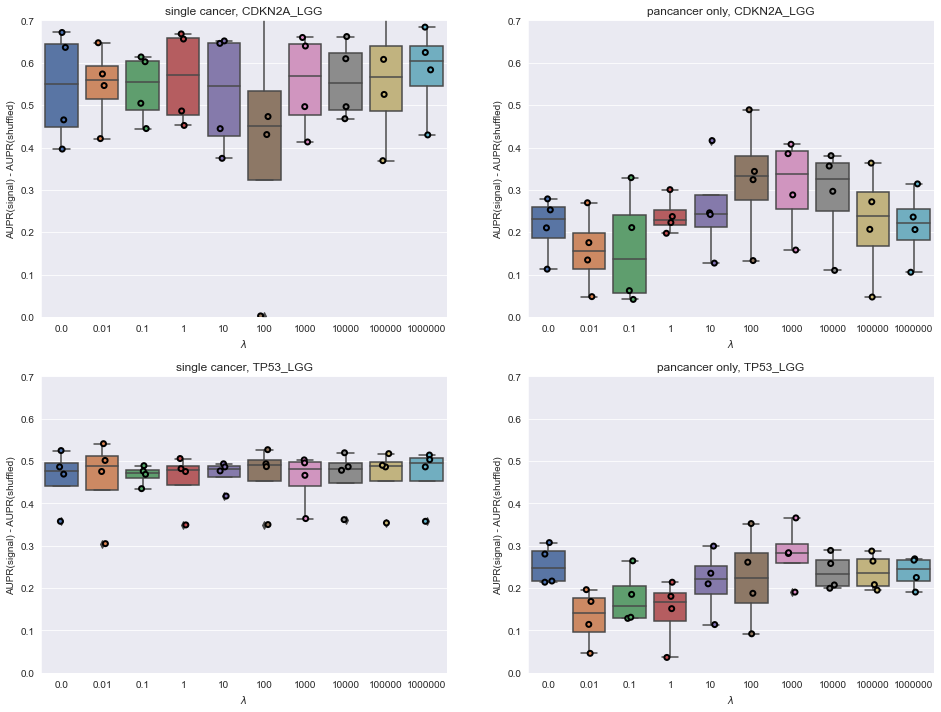

In [8]:
sns.set({'figure.figsize': (16, 12)})
fig, axarr = plt.subplots(2, 2)


plot_df = diff_results_df[(diff_results_df.train_set == 'single_cancer') &
                          (diff_results_df.identifier == 'CDKN2A_LGG')]
sns.boxplot(data=plot_df, x='lambda', y='delta_aupr', ax=axarr[0, 0])
sns.stripplot(data=plot_df, x='lambda', y='delta_aupr', dodge=True,
              edgecolor='black', linewidth=2, ax=axarr[0, 0])
axarr[0, 0].set_ylim(0.0, 0.7)
axarr[0, 0].set_xlabel(r'$\lambda$')
axarr[0, 0].set_ylabel('AUPR(signal) - AUPR(shuffled)')
axarr[0, 0].set_title('single cancer, CDKN2A_LGG')
         
plot_df = diff_results_df[(diff_results_df.train_set == 'pancancer_only') &
                          (diff_results_df.identifier == 'CDKN2A_LGG')]
sns.boxplot(data=plot_df, x='lambda', y='delta_aupr', ax=axarr[0, 1])
sns.stripplot(data=plot_df, x='lambda', y='delta_aupr', dodge=True,
              edgecolor='black', linewidth=2, ax=axarr[0, 1])
axarr[0, 1].set_ylim(0.0, 0.7)
axarr[0, 1].set_xlabel(r'$\lambda$')
axarr[0, 1].set_ylabel('AUPR(signal) - AUPR(shuffled)')
axarr[0, 1].set_title('pancancer only, CDKN2A_LGG')
         
plot_df = diff_results_df[(diff_results_df.train_set == 'single_cancer') &
                          (diff_results_df.identifier == 'TP53_LGG')]
sns.boxplot(data=plot_df, x='lambda', y='delta_aupr', ax=axarr[1, 0])
sns.stripplot(data=plot_df, x='lambda', y='delta_aupr', dodge=True,
              edgecolor='black', linewidth=2, ax=axarr[1, 0])
axarr[1, 0].set_ylim(0.0, 0.7)
axarr[1, 0].set_xlabel(r'$\lambda$')
axarr[1, 0].set_ylabel('AUPR(signal) - AUPR(shuffled)')
axarr[1, 0].set_title('single cancer, TP53_LGG')

plot_df = diff_results_df[(diff_results_df.train_set == 'pancancer_only') &
                          (diff_results_df.identifier == 'TP53_LGG')]
sns.boxplot(data=plot_df, x='lambda', y='delta_aupr', ax=axarr[1, 1])
sns.stripplot(data=plot_df, x='lambda', y='delta_aupr', dodge=True,
              edgecolor='black', linewidth=2, ax=axarr[1, 1])
axarr[1, 1].set_ylim(0.0, 0.7)
axarr[1, 1].set_xlabel(r'$\lambda$')
axarr[1, 1].set_ylabel('AUPR(signal) - AUPR(shuffled)')
axarr[1, 1].set_title('pancancer only, TP53_LGG')

In [9]:
# TCA, linear kernel

mu_vals = [0.1, 1, 10, 100]

tca_df = pd.DataFrame()

for mu in mu_vals:
    tca_single_cancer_df = au.load_prediction_results(
        os.path.join(cfg.results_dir,
                     'tca',
                     # 'tca_results_linear_{}'.format(mu),
                     'tca_results_rbf_{}'.format(mu),
                     'single_cancer'),
        'single_cancer'
    )
    tca_single_cancer_df['mu'] = mu
    tca_pancancer_df = au.load_prediction_results(
        os.path.join(cfg.results_dir,
                     'tca',
                     'tca_results_rbf_{}'.format(mu),
                     'pancancer_only'),
        'pancancer_only'
    )
    tca_pancancer_df['mu'] = mu
    tca_df = pd.concat((tca_df, tca_single_cancer_df, tca_pancancer_df))
tca_df['tca'] = True
tca_df.head()

,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,train_set,identifier,mu,tca
0,0.98730,0.98950,TP53,LGG,signal,42,train,0,single_cancer,TP53_LGG,0.1,True
1,0.61278,0.59306,TP53,LGG,signal,42,test,0,single_cancer,TP53_LGG,0.1,True
2,0.54695,0.54535,TP53,LGG,signal,42,cv,0,single_cancer,TP53_LGG,0.1,True
3,0.52639,0.51993,TP53,LGG,signal,42,train,1,single_cancer,TP53_LGG,0.1,True
4,0.55881,0.51689,TP53,LGG,signal,42,test,1,single_cancer,TP53_LGG,0.1,True


In [10]:
# just use the coral control for now, should be the same
control_single_cancer_df = au.load_prediction_results(
    os.path.join(cfg.results_dir,
                 'coral',
                 'coral_control',
                 'single_cancer'),
    'single_cancer'
)
control_pancancer_df = au.load_prediction_results(
    os.path.join(cfg.results_dir,
                 'coral',
                 'coral_control',
                 'pancancer_only'),
    'pancancer_only'
)
control_df = pd.concat((control_single_cancer_df, control_pancancer_df))
control_df['mu'] = 0
control_df['tca'] = False
control_df.head()

,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,train_set,identifier,mu,tca
0,0.97655,0.98157,TP53,LGG,signal,42,train,0,single_cancer,TP53_LGG,0,False
1,0.95589,0.94132,TP53,LGG,signal,42,test,0,single_cancer,TP53_LGG,0,False
2,0.95770,0.96404,TP53,LGG,signal,42,cv,0,single_cancer,TP53_LGG,0,False
3,0.98295,0.98336,TP53,LGG,signal,42,train,1,single_cancer,TP53_LGG,0,False
4,0.97543,0.97588,TP53,LGG,signal,42,test,1,single_cancer,TP53_LGG,0,False


In [11]:
results_df = pd.concat((tca_df, control_df))
results_df.head()

,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,train_set,identifier,mu,tca
0,0.98730,0.98950,TP53,LGG,signal,42,train,0,single_cancer,TP53_LGG,0.1,True
1,0.61278,0.59306,TP53,LGG,signal,42,test,0,single_cancer,TP53_LGG,0.1,True
2,0.54695,0.54535,TP53,LGG,signal,42,cv,0,single_cancer,TP53_LGG,0.1,True
3,0.52639,0.51993,TP53,LGG,signal,42,train,1,single_cancer,TP53_LGG,0.1,True
4,0.55881,0.51689,TP53,LGG,signal,42,test,1,single_cancer,TP53_LGG,0.1,True


In [12]:
diff_results_df = pd.DataFrame()
for train_set in ['single_cancer', 'pancancer_only']:
    for mu in mu_vals + [0.0]:
        print(mu)
        data_df = results_df[(results_df.train_set == train_set) &
                             (results_df['mu'] == mu)]
        diff_df = au.compare_control_ind(data_df,
                                         identifier='identifier',
                                         metric='aupr',
                                         verbose=True)
        diff_df['train_set'] = train_set
        diff_df['mu'] = mu
        diff_df['tca'] = (mu == 0)
        diff_results_df = pd.concat((diff_results_df, diff_df))
        
diff_results_df.head()

0.1
1
10
100
0.0
0.1
1
10
100
0.0


,identifier,seed,fold,delta_aupr,train_set,mu,tca
0,CDKN2A_LGG,42,0,0.259410,single_cancer,0.1,False
1,CDKN2A_LGG,42,1,0.062550,single_cancer,0.1,False
2,CDKN2A_LGG,42,2,0.135350,single_cancer,0.1,False
3,CDKN2A_LGG,42,3,0.104354,single_cancer,0.1,False
4,TP53_LGG,42,0,0.138670,single_cancer,0.1,False


Text(0.5, 1.0, 'pancancer only, TP53_LGG')

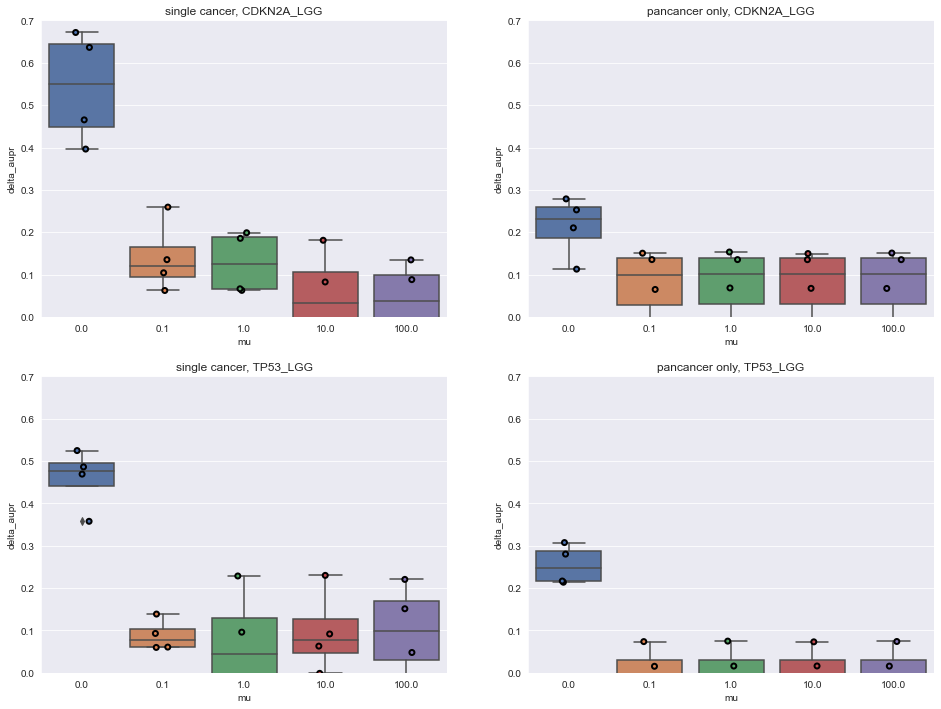

In [13]:
sns.set({'figure.figsize': (16, 12)})
fig, axarr = plt.subplots(2, 2)

plot_df = diff_results_df[(diff_results_df.train_set == 'single_cancer') &
                          (diff_results_df.identifier == 'CDKN2A_LGG')]
sns.boxplot(data=plot_df, x='mu', y='delta_aupr', ax=axarr[0, 0])
sns.stripplot(data=plot_df, x='mu', y='delta_aupr', dodge=True,
              edgecolor='black', linewidth=2, ax=axarr[0, 0])
axarr[0, 0].set_ylim(0.0, 0.7)
axarr[0, 0].set_title('single cancer, CDKN2A_LGG')
         
plot_df = diff_results_df[(diff_results_df.train_set == 'pancancer_only') &
                          (diff_results_df.identifier == 'CDKN2A_LGG')]
sns.boxplot(data=plot_df, x='mu', y='delta_aupr', ax=axarr[0, 1])
sns.stripplot(data=plot_df, x='mu', y='delta_aupr', dodge=True,
              edgecolor='black', linewidth=2, ax=axarr[0, 1])
axarr[0, 1].set_ylim(0.0, 0.7)
axarr[0, 1].set_title('pancancer only, CDKN2A_LGG')
         
plot_df = diff_results_df[(diff_results_df.train_set == 'single_cancer') &
                          (diff_results_df.identifier == 'TP53_LGG')]
sns.boxplot(data=plot_df, x='mu', y='delta_aupr', ax=axarr[1, 0])
sns.stripplot(data=plot_df, x='mu', y='delta_aupr', dodge=True,
              edgecolor='black', linewidth=2, ax=axarr[1, 0])
axarr[1, 0].set_ylim(0.0, 0.7)
axarr[1, 0].set_title('single cancer, TP53_LGG')

plot_df = diff_results_df[(diff_results_df.train_set == 'pancancer_only') &
                          (diff_results_df.identifier == 'TP53_LGG')]
sns.boxplot(data=plot_df, x='mu', y='delta_aupr', ax=axarr[1, 1])
sns.stripplot(data=plot_df, x='mu', y='delta_aupr', dodge=True,
              edgecolor='black', linewidth=2, ax=axarr[1, 1])
axarr[1, 1].set_ylim(0.0, 0.7)
axarr[1, 1].set_title('pancancer only, TP53_LGG')